<a href="https://colab.research.google.com/github/DavidEPP/NLP_disaster_tweet_classifier/blob/main/RNN_for_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nlp_getting_started_path = kagglehub.competition_download('nlp-getting-started')

print('Data source import complete.')


100%|██████████| 593k/593k [00:00<00:00, 889kB/s]

Extracting files...
Data source import complete.


<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available.

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [73]:
import os
import numpy as np
import pandas as pd
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import F1Score, BinaryAccuracy


from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [5]:
print (f"The data is loaded to {nlp_getting_started_path}")
df_train = pd.read_csv(f"{nlp_getting_started_path}/train.csv")
df_test = pd.read_csv(f"{nlp_getting_started_path}/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

The data is loaded to /root/.cache/kagglehub/competitions/nlp-getting-started
Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [6]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

In [7]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

# Explore the dataset

In [8]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [9]:
print(df_train.isna().sum())
print(df_test.isna().sum())

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64
id             0
keyword       26
location    1105
text           0
length         0
dtype: int64


We can note that some of the tweets do not include a keyword or a location. In the first attempt, those will not be considered.

In [10]:
print (f'{len(df_train["location"].unique())} different locations')
print (f'{len(df_train["keyword"].unique())} different keywords')

3342 different locations
222 different keywords


We can check for inconsistent tags (same text with different target).

In [11]:
# Count the duplicated values in the 'Text' column
duplicated_text_count = df_train.duplicated(subset=['text']).sum()

# Count the duplicated values based on both 'Text' and 'Category'. If the counts are the same as above,those duplicates have consistent 'Category'
duplicated_textcat_count = df_train.duplicated(subset=['text', 'target']).sum()

# Print the counts
print(f'There are {duplicated_text_count} rows with the same texts in the training data.')
print(f'There are {duplicated_textcat_count} rows with the same texts and categories in the training data.')





There are 110 rows with the same texts in the training data.
There are 92 rows with the same texts and categories in the training data.


There are some registers with the same text but different tag. These should be excluded from the study

In [12]:
inconsistent_texts = (
    df_train.groupby('text')['target']
    .nunique()
    .loc[lambda x: x > 1]  # Find names with more than 1 unique tag
    .index
)

print(f"There are {len(inconsistent_texts)} texts which are both clasified as disaster and non-disaster")

There are 18 texts which are both clasified as disaster and non-disaster


such texts must be removed from the original dataframe before continuing the analysis.

In [13]:

#  Remove rows with inconsistent text classification
df_train_cleaned = df_train[~df_train['text'].isin(inconsistent_texts)]

print(f"the cleand dataframe has {len(df_train_cleaned)} entries")


the cleand dataframe has 7558 entries


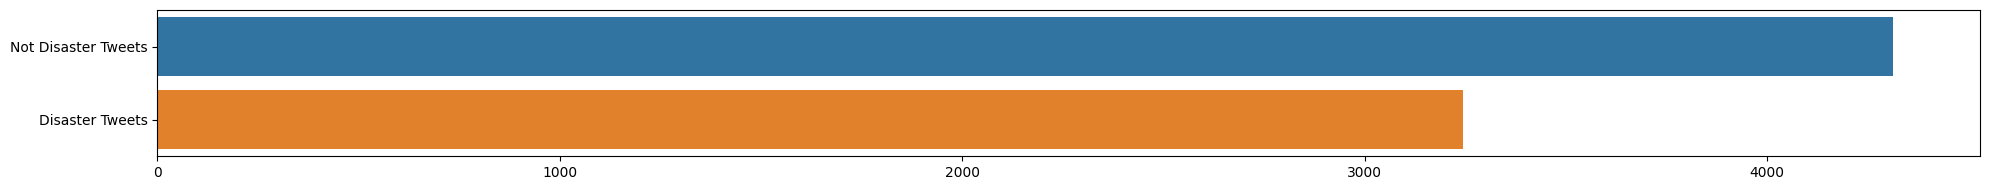

In [14]:
# We now see the corresponding distribution of the categories

labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_train_cleaned[df_train_cleaned['target'] == 0].shape[0], df_train_cleaned[df_train_cleaned['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values,hue=labels)
plt.tight_layout();


The inconsistent tags are a serious problem, but also there might be a problem in case of consistent repeated texts, as they could cause overftting. They will be removed now

In [15]:
# Remove duplicates
df_train_cleaned = df_train_cleaned.drop_duplicates(subset=['text'])

# Check train data counts. Originally training data has 1490 rows and 50 rows should be dropped. So, I expect 1440 rows left.
print(f'Samples in training data after moving duplicates: {df_train_cleaned.shape[0]}')



Samples in training data after moving duplicates: 7485


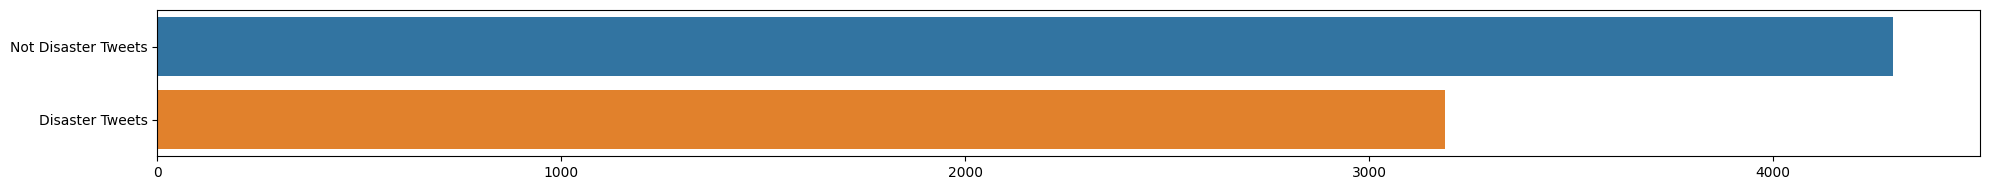

In [16]:
# We now see the corresponding distribution of the categories

labels = ["Not Disaster Tweets", "Disaster Tweets",]
values = [df_train_cleaned[df_train_cleaned['target'] == 0].shape[0], df_train_cleaned[df_train_cleaned['target'] == 1].shape[0]]

plt.figure(figsize=(20, 2))
sns.barplot(y=labels, x=values,hue=labels)
plt.tight_layout();

# Preprocess the data

In [17]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
SEED = 412294
EPOCHS = 2
AUTO = tf.data.experimental.AUTOTUNE

In [18]:
from sklearn.model_selection import train_test_split

X = df_train_cleaned["text"]
y = df_train_cleaned["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=SEED)

X_test = df_test["text"]

In [19]:
#!python3 -m pip install wordninja num2words mplcyberpunk spacy==3.5.3

#!python3 -m spacy download en_core_web_lg


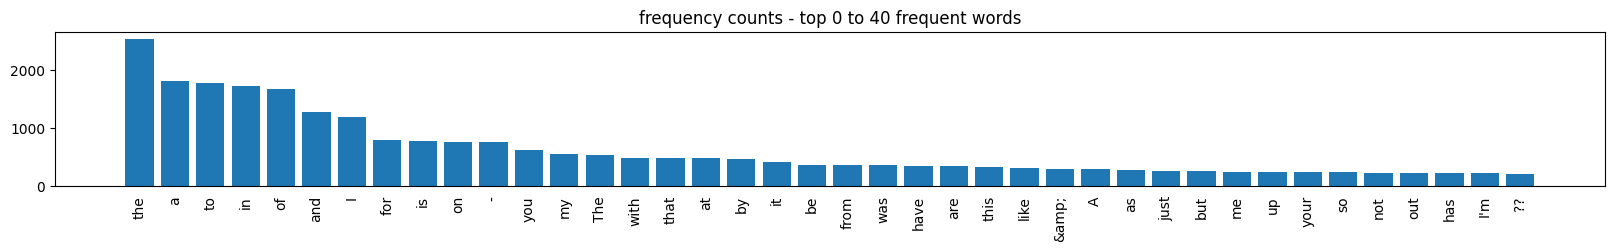

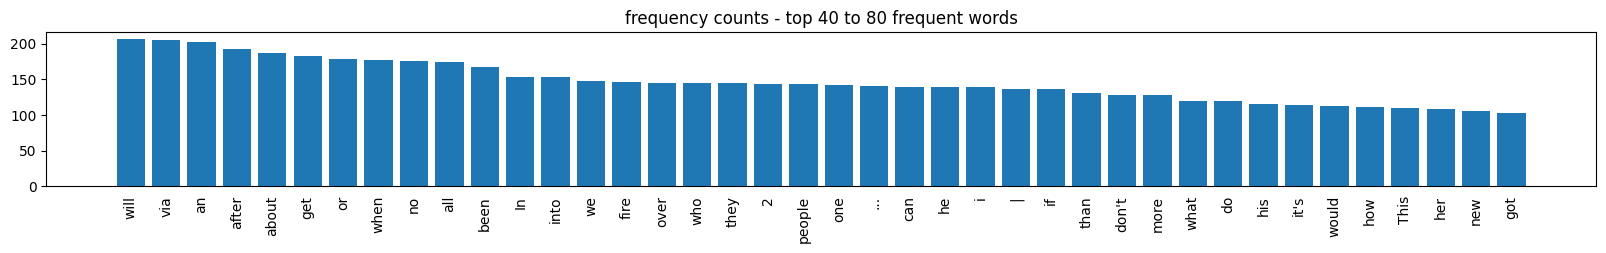

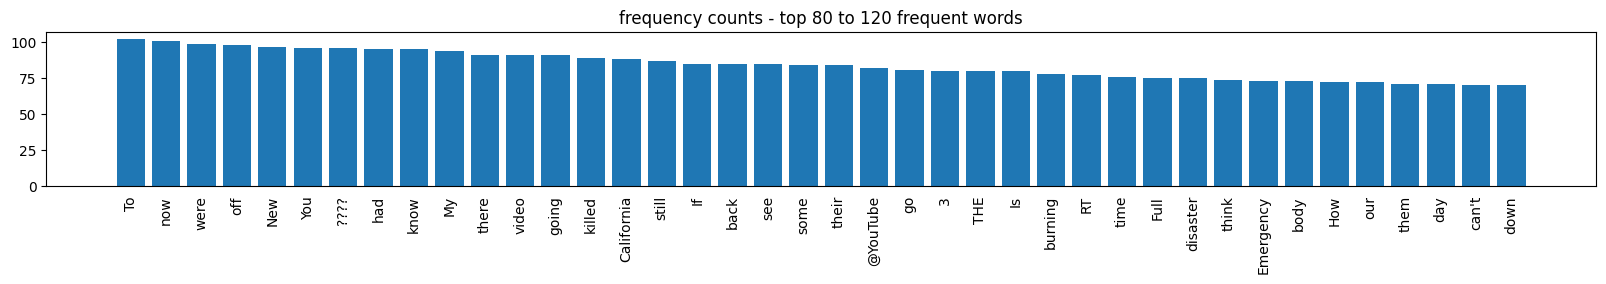

In [20]:
# plot some most frequent words
def frequency_plot(frequency,start,end):
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency)
    plt.title(f'frequency counts - top {start} to {end} frequent words')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency = df_train_cleaned['text'].str.split().explode().value_counts()


frequency_plot(frequency,0,40)
frequency_plot(frequency, 40,80)
frequency_plot(frequency, 80,120)

We note first that connecting words (the, a, an, and, to,
of,...) are among the most common ones, but they do not add any context to the text. <br>
They will be removed (by being considered "stop words"). Also, we see that as expected some words start by a "hashtag" since it is used for tagging in twitter. Hyperlinks also appear as can be seen below <br>
Some texts also contains emoticons, so this will also be threated as separate words instead of being considered punctuation.<br>
Words wll then need to be tokenized (for instance using the root). Finally, each tweet will be vectorized.  

In [21]:
print(len(frequency))
display(frequency.sort_index()[1000:1010])
frequency.sort_index()[21000:21010]

31870


text
#SuryaRay    1
#Susiya      1
#Suspense    1
#Swag        1
#Sydney      1
#Syria       2
#Syria.      1
#Syrian      1
#TAFS        1
#TBT         4
Name: count, dtype: int64

text
http://t.co/5BGcw3EzB5    1
http://t.co/5CGtqfk2uR    1
http://t.co/5Cm0LfZhxn    1
http://t.co/5CwUyLnFUm    1
http://t.co/5EBpYbFH4D    1
http://t.co/5FcJVMl520    1
http://t.co/5G8qA6mPxm    1
http://t.co/5GKTSHioRR    1
http://t.co/5IyZsDA6xB    1
http://t.co/5KohO39oJE    1
Name: count, dtype: int64

The following shows the most common words both in the disaster and non-disaster categories.

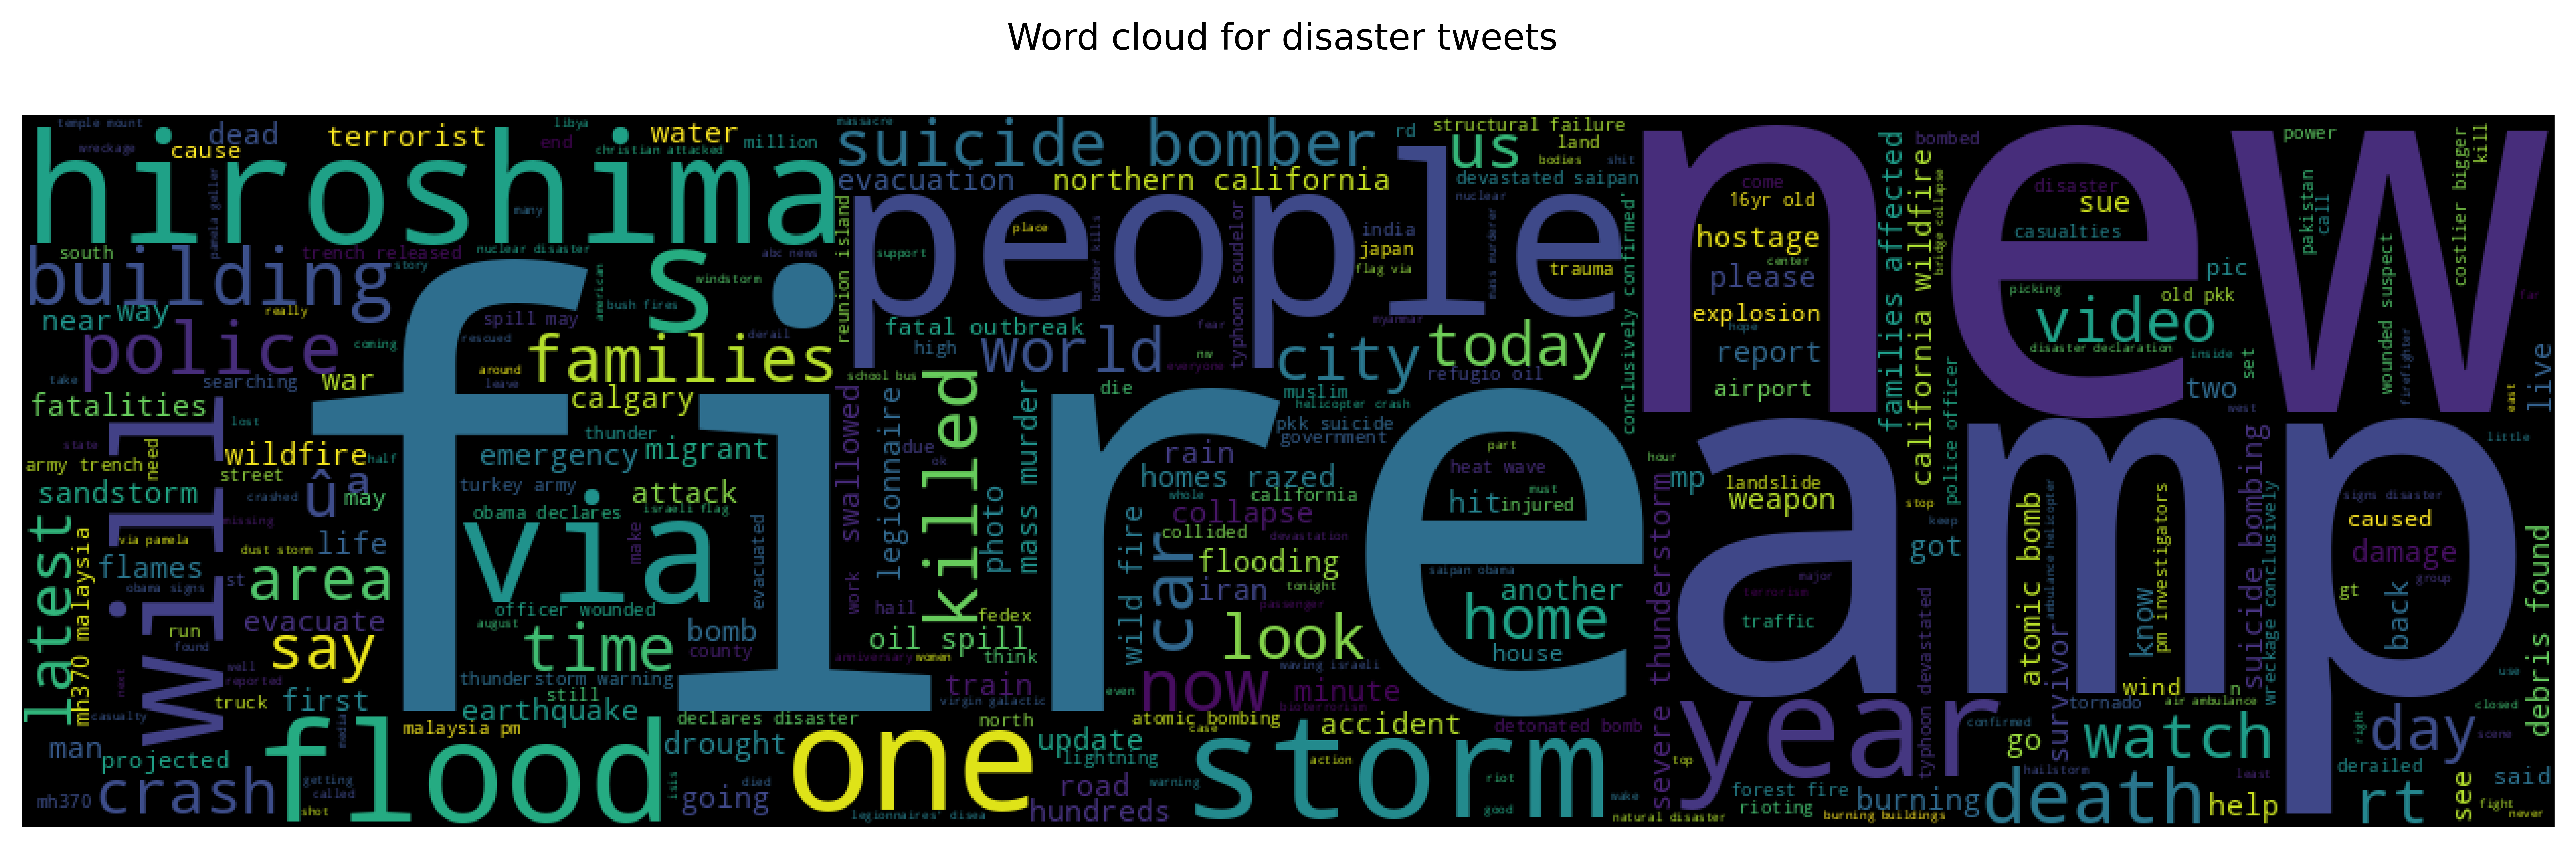

In [22]:
from wordcloud import WordCloud, STOPWORDS


aux = STOPWORDS.copy()
aux.update(["t"])
aux.update(["co"])
aux.update(["https"])
aux.update(["w"])
aux.update(["Û_"])
aux.update(["Û"])
aux.update(["U"])
aux.update(["ûᵃ"])
aux.update(["ûò"])

alltext = ' '.join(df_train_cleaned.loc[df_train_cleaned['target'] == 1, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(12, 4), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.suptitle("Word cloud for disaster tweets ")
plt.tight_layout();



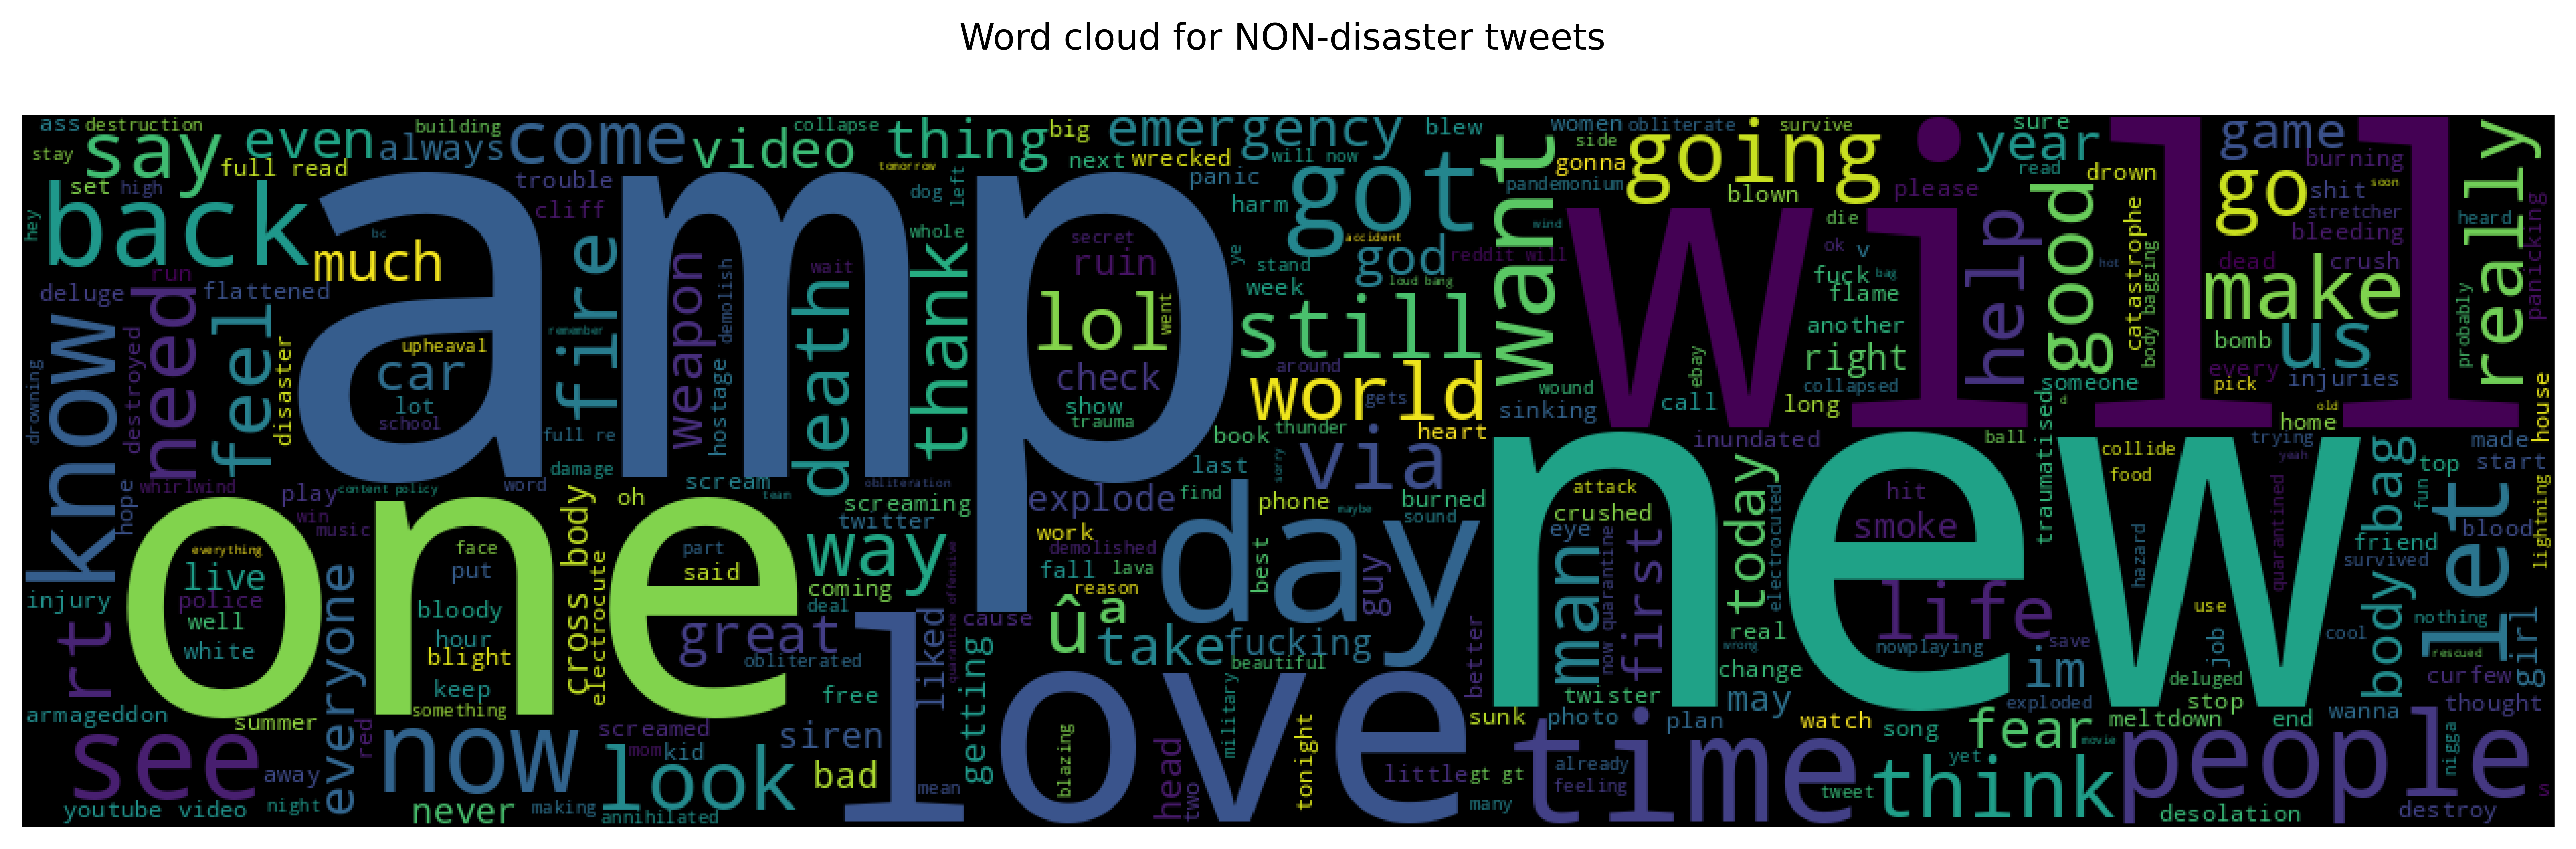

In [23]:
alltext = ' '.join(df_train_cleaned.loc[df_train_cleaned['target'] == 0, "text"])
word_cloud = WordCloud(width=1280, height=360, stopwords=aux, max_words=300).generate(text=alltext.lower())

plt.figure(figsize=(12, 4), dpi=1000)
plt.imshow(word_cloud)
plt.axis("off")
plt.suptitle("Word cloud for NON-disaster tweets ")
plt.tight_layout();

In [24]:
print(f"The {len(aux)} stopwords like {list(aux)[:5]} will not be considered in the cleaned data")

The 201 stopwords like ['ûò', 'otherwise', 'them', 'further', 'https'] will not be considered in the cleaned data


In [26]:
!pip install nltk --upgrade

In [25]:
# function for text preprocessing
import re
# nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')  # Download stopwords dataset"stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer



EMOTICONS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def text_preprocessing(df):
    """
    This function does in place replacement of data so it won't return anything.
    Some symbols will be substituted by their corresponding words
    """
    # convert to lower cases
    df['text']=df['text'].str.lower()

    # change symbols
    df['text'] = df['text'].apply(lambda doc: re.sub('\\$', ' dollar ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('£', ' pound sterling ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('€',  ' euro ',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub('%20', ' ',doc)) # in the keywords %20 is the code for " "

    df['text'] = df['text'].apply(lambda doc: re.sub('%', ' percent ',doc)) # eliminates dots ans spaces between numbers

    df['text'] = df['text'].apply(lambda doc: re.sub(r'(\d)\.\s', r'\1',doc)) # eliminates dots ans spaces between numbers
    df['text'] = df['text'].apply(lambda doc: re.sub("\#", "aHashtag ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("([0-9])+", " aNumber ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("\@", "aMention ",doc)) # Replaces digits by "X"
    df['text'] = df['text'].apply(lambda doc: re.sub("http", "anUrl ",doc)) # Replaces digits by "X"

    #changing emoticons
    for palabra, emoticon in EMOTICONS.items():
      df['text'] = df['text'].apply(lambda doc: re.sub(emoticon, f" aNemoji {palabra} ",doc)) # Replaces emoticon with its

    df['text'] = df['text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc)) #remove punctuation


    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')+list(aux)
    df['text'] = df['text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))



    # remove extra spaces
    df['text'] = df['text'].apply(lambda doc: re.sub(' +', ' ', doc))

    # stemming
    porter_stemmer = PorterStemmer()
    df['text'] = df['text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['text'] = df['text'].apply(lambda words: ' '.join(words))

# take a look at text 0
train_copy = df_train_cleaned.copy().fillna('')
test_copy = df_test.copy().fillna('')

print('1st text before preprocessing: \n',train_copy['text'][0])
text_preprocessing(train_copy)
text_preprocessing(test_copy)

print('\n1st text after preprocessing: \n',train_copy['text'][0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1st text before preprocessing: 
 Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

1st text after preprocessing: 
 deed reason ahashtag earthquak may allah forgiv us


In [27]:
print ((train_copy['text'][1]))

forest fire near la rong sask canada


In [28]:
def get_textData(clean_text):
  num_hashtags = clean_text.count('ahashtag')
  num_mentions = clean_text.count('ament')
  num_numbers = clean_text.count('anumb')
  num_urls = clean_text.count('anurl')
  num_emojis = clean_text.count('anemoji')

  return clean_text, len(clean_text.split()), len(clean_text), num_hashtags, num_mentions, num_urls, num_numbers, num_emojis
print (get_textData(train_copy['text'][1]))

('forest fire near la rong sask canada', 7, 36, 0, 0, 0, 0)


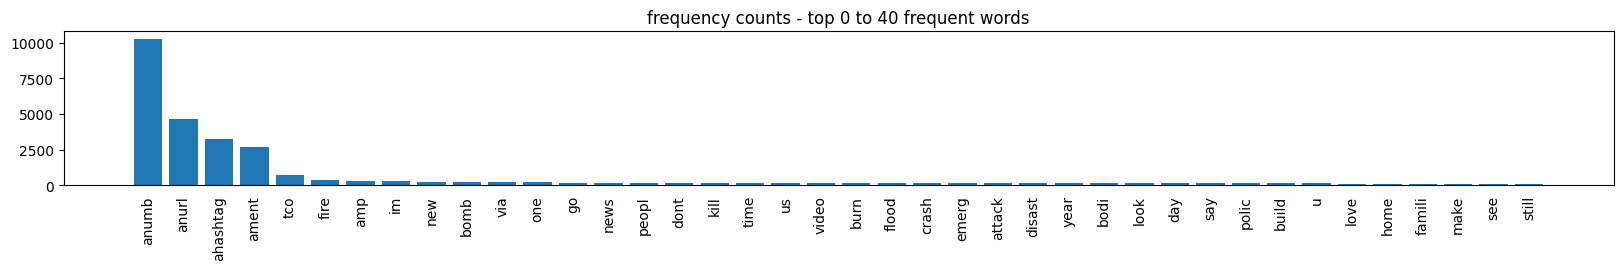

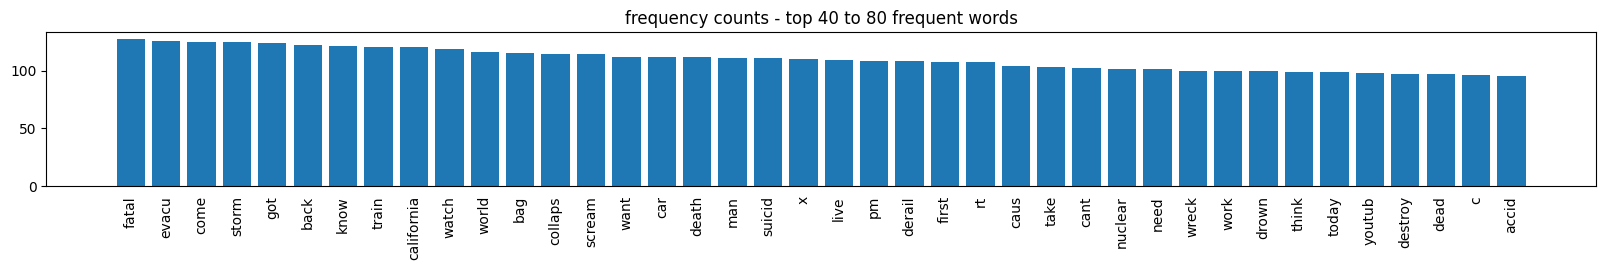

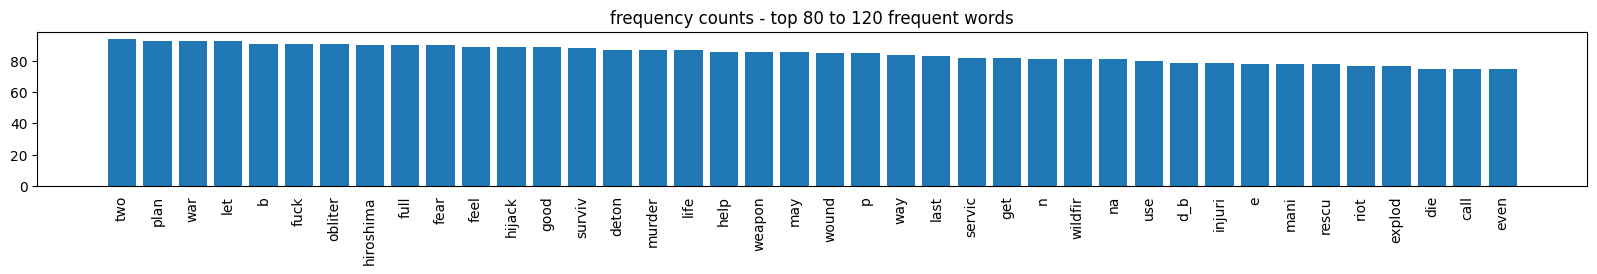

In [29]:
frequency = train_copy['text'].str.split().explode().value_counts()

frequency_plot(frequency,0,40)
frequency_plot(frequency, 40,80)
frequency_plot(frequency, 80,120)

Now, we need to tokenize the words and get a numeric dataframe that will be the input to our corresponding RNN models

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
def tokenize(text, tokenizer, fit=False):
    if fit == True:
        tokenizer.fit_on_texts(text)
    return tokenizer.texts_to_sequences(text)

tokenizer = Tokenizer(oov_token="<OOV>")
tokenized_text = tokenize(train_copy['text'][1], tokenizer, fit=True)
print (tokenized_text)

[[7], [8], [3], [4], [5], [9], [], [7], [10], [3], [4], [], [6], [4], [2], [3], [], [11], [2], [], [3], [8], [6], [12], [], [5], [2], [5], [13], [], [14], [2], [6], [2], [15], [2]]


Setting a seed will help for reproducing the same results

In [31]:
train_copy["clean_text"],train_copy["n_words"], train_copy["n_characters"], train_copy["n_hashtags"], train_copy["n_mentions"], train_copy["n_urls"],train_copy["n_numbers"],train_copy["n_emojis"],  = zip(*train_copy["text"].apply(lambda text: get_textData(text)))
train_copy["n_keywords"]  = list(zip(*train_copy["keyword"].apply(lambda text: get_textData(text))))[1]
train_copy["n_location"]  = list(zip(*train_copy["location"].apply(lambda text: get_textData(text))))[1]

train_copy

id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7604  10863                    
7605  10864                    
7606  10866                    
7608  10869                    
7612  10873                    

                                                   text  target  length  \
0     deed reason ahashtag earthquak may allah forgi...       1      69   
1                  forest fire near la rong sask canada       1      38   
2     resid ask shelter place notifi offic evacu she...       1     133   
3     anumb anumb peopl receiv ahashtag wildfir evac...       1      65   
4     got sent photo rubi ahashtag alaska smoke ahas...       1      88   
...                                                 ...     ...     ...   
7604  ahashtag worldnew fallen powerlin glink tram u...       1     136   
7605  flip side im walmart bomb everyon evacu stay t...       1     114   
7606  suicid bomber kill anumb saudi secur site mosq...       1     121   
7608  two giant crane hold bridg collaps nearbi home...       1      83   
7612  latest home raze northern california wildfir a...       1      94   

                                             clean_text  n_words  \
0     deed reason ahashtag earthquak may allah forgi...        8   
1                  forest fire near la rong sask canada        7   
2     resid ask shelter place notifi offic evacu she...       11   
3     anumb anumb peopl receiv ahashtag wildfir evac...        9   
4     got sent photo rubi ahashtag alaska smoke ahas...       11   
...                                                 ...      ...   
7604  ahashtag worldnew fallen powerlin glink tram u...       17   
7605  flip side im walmart bomb everyon evacu stay t...       10   
7606  suicid bomber kill anumb saudi secur site mosq...       18   
7608  two giant crane hold bridg collaps nearbi home...       11   
7612  latest home raze northern california wildfir a...       13   

      n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_keywords  
0               50           1           0       0          0           0  
1               36           0           0       0          0           0  
2               69           0           0       0          0           0  
3               64           1           0       0          2           0  
4               70           2           0       0          0           0  
...            ...         ...         ...     ...        ...         ...  
7604           109           1           0       1          2           0  
7605            54           0           0       0          0           0  
7606           105           0           0       1          2           0  
7608            71           0           0       1          1           0  
7612            83           0           0       1          2           0  

[7485 rows x 14 columns]

In [32]:
max_length_tweet = 144
max_length_keyword = 8


In [33]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_tokens(text, max_length, fit=False, padding=False):
    preprocessed_text = tokenize(text, tokenizer, fit)
    if padding:
        preprocessed_text = pad_sequences(preprocessed_text, maxlen=max_length, padding='post')
    return preprocessed_text

train_copy["tokenized_text"] = list(get_tokens(train_copy["clean_text"].tolist(), max_length=max_length_tweet, fit=True, padding=True))
train_copy["tokenized_keyword"] = list(get_tokens(train_copy["keyword"].tolist(), max_length=max_length_keyword, fit=True, padding=True))
train_copy["tokenized_location"] = list(get_tokens(train_copy["location"].tolist(), max_length=max_length_keyword, fit=True, padding=True))

train_copy.head()

id keyword location                                               text  \
0   1                   deed reason ahashtag earthquak may allah forgi...   
1   4                                forest fire near la rong sask canada   
2   5                   resid ask shelter place notifi offic evacu she...   
3   6                   anumb anumb peopl receiv ahashtag wildfir evac...   
4   7                   got sent photo rubi ahashtag alaska smoke ahas...   

   target  length                                         clean_text  n_words  \
0       1      69  deed reason ahashtag earthquak may allah forgi...        8   
1       1      38               forest fire near la rong sask canada        7   
2       1     133  resid ask shelter place notifi offic evacu she...       11   
3       1      65  anumb anumb peopl receiv ahashtag wildfir evac...        9   
4       1      88  got sent photo rubi ahashtag alaska smoke ahas...       11   

   n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_keywords  \
0            50           1           0       0          0           0   
1            36           0           0       0          0           0   
2            69           0           0       0          0           0   
3            64           1           0       0          2           0   
4            70           2           0       0          0           0   

                                      tokenized_text  \
0  [4002, 480, 4, 235, 98, 1899, 3117, 20, 0, 0, ...   
1  [155, 7, 219, 481, 5879, 5880, 1077, 0, 0, 0, ...   
2  [1409, 541, 1900, 418, 2169, 241, 44, 1900, 41...   
3  [2, 2, 16, 2572, 4, 111, 44, 380, 51, 0, 0, 0,...   
4  [47, 1078, 156, 4003, 4, 1701, 220, 4, 111, 25...   

          tokenized_keyword        tokenized_location  
0  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
1  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
2  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
3  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]  
4  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]

In [34]:


vocab_size = len(tokenizer.word_index) + 1
print(f"The tokenizer found {vocab_size} different words")


The tokenizer found 22779 different words


In [35]:
import itertools
print(dict(itertools.islice(tokenizer.index_word.items(), 20)))

{1: '<OOV>', 2: 'anumb', 3: 'anurl', 4: 'ahashtag', 5: 'ament', 6: 'tco', 7: 'new', 8: 'fire', 9: 'im', 10: 'amp', 11: 'usa', 12: 'bomb', 13: 'via', 14: 'news', 15: 'one', 16: 'go', 17: 'california', 18: 'flood', 19: 'crash', 20: 'us'}


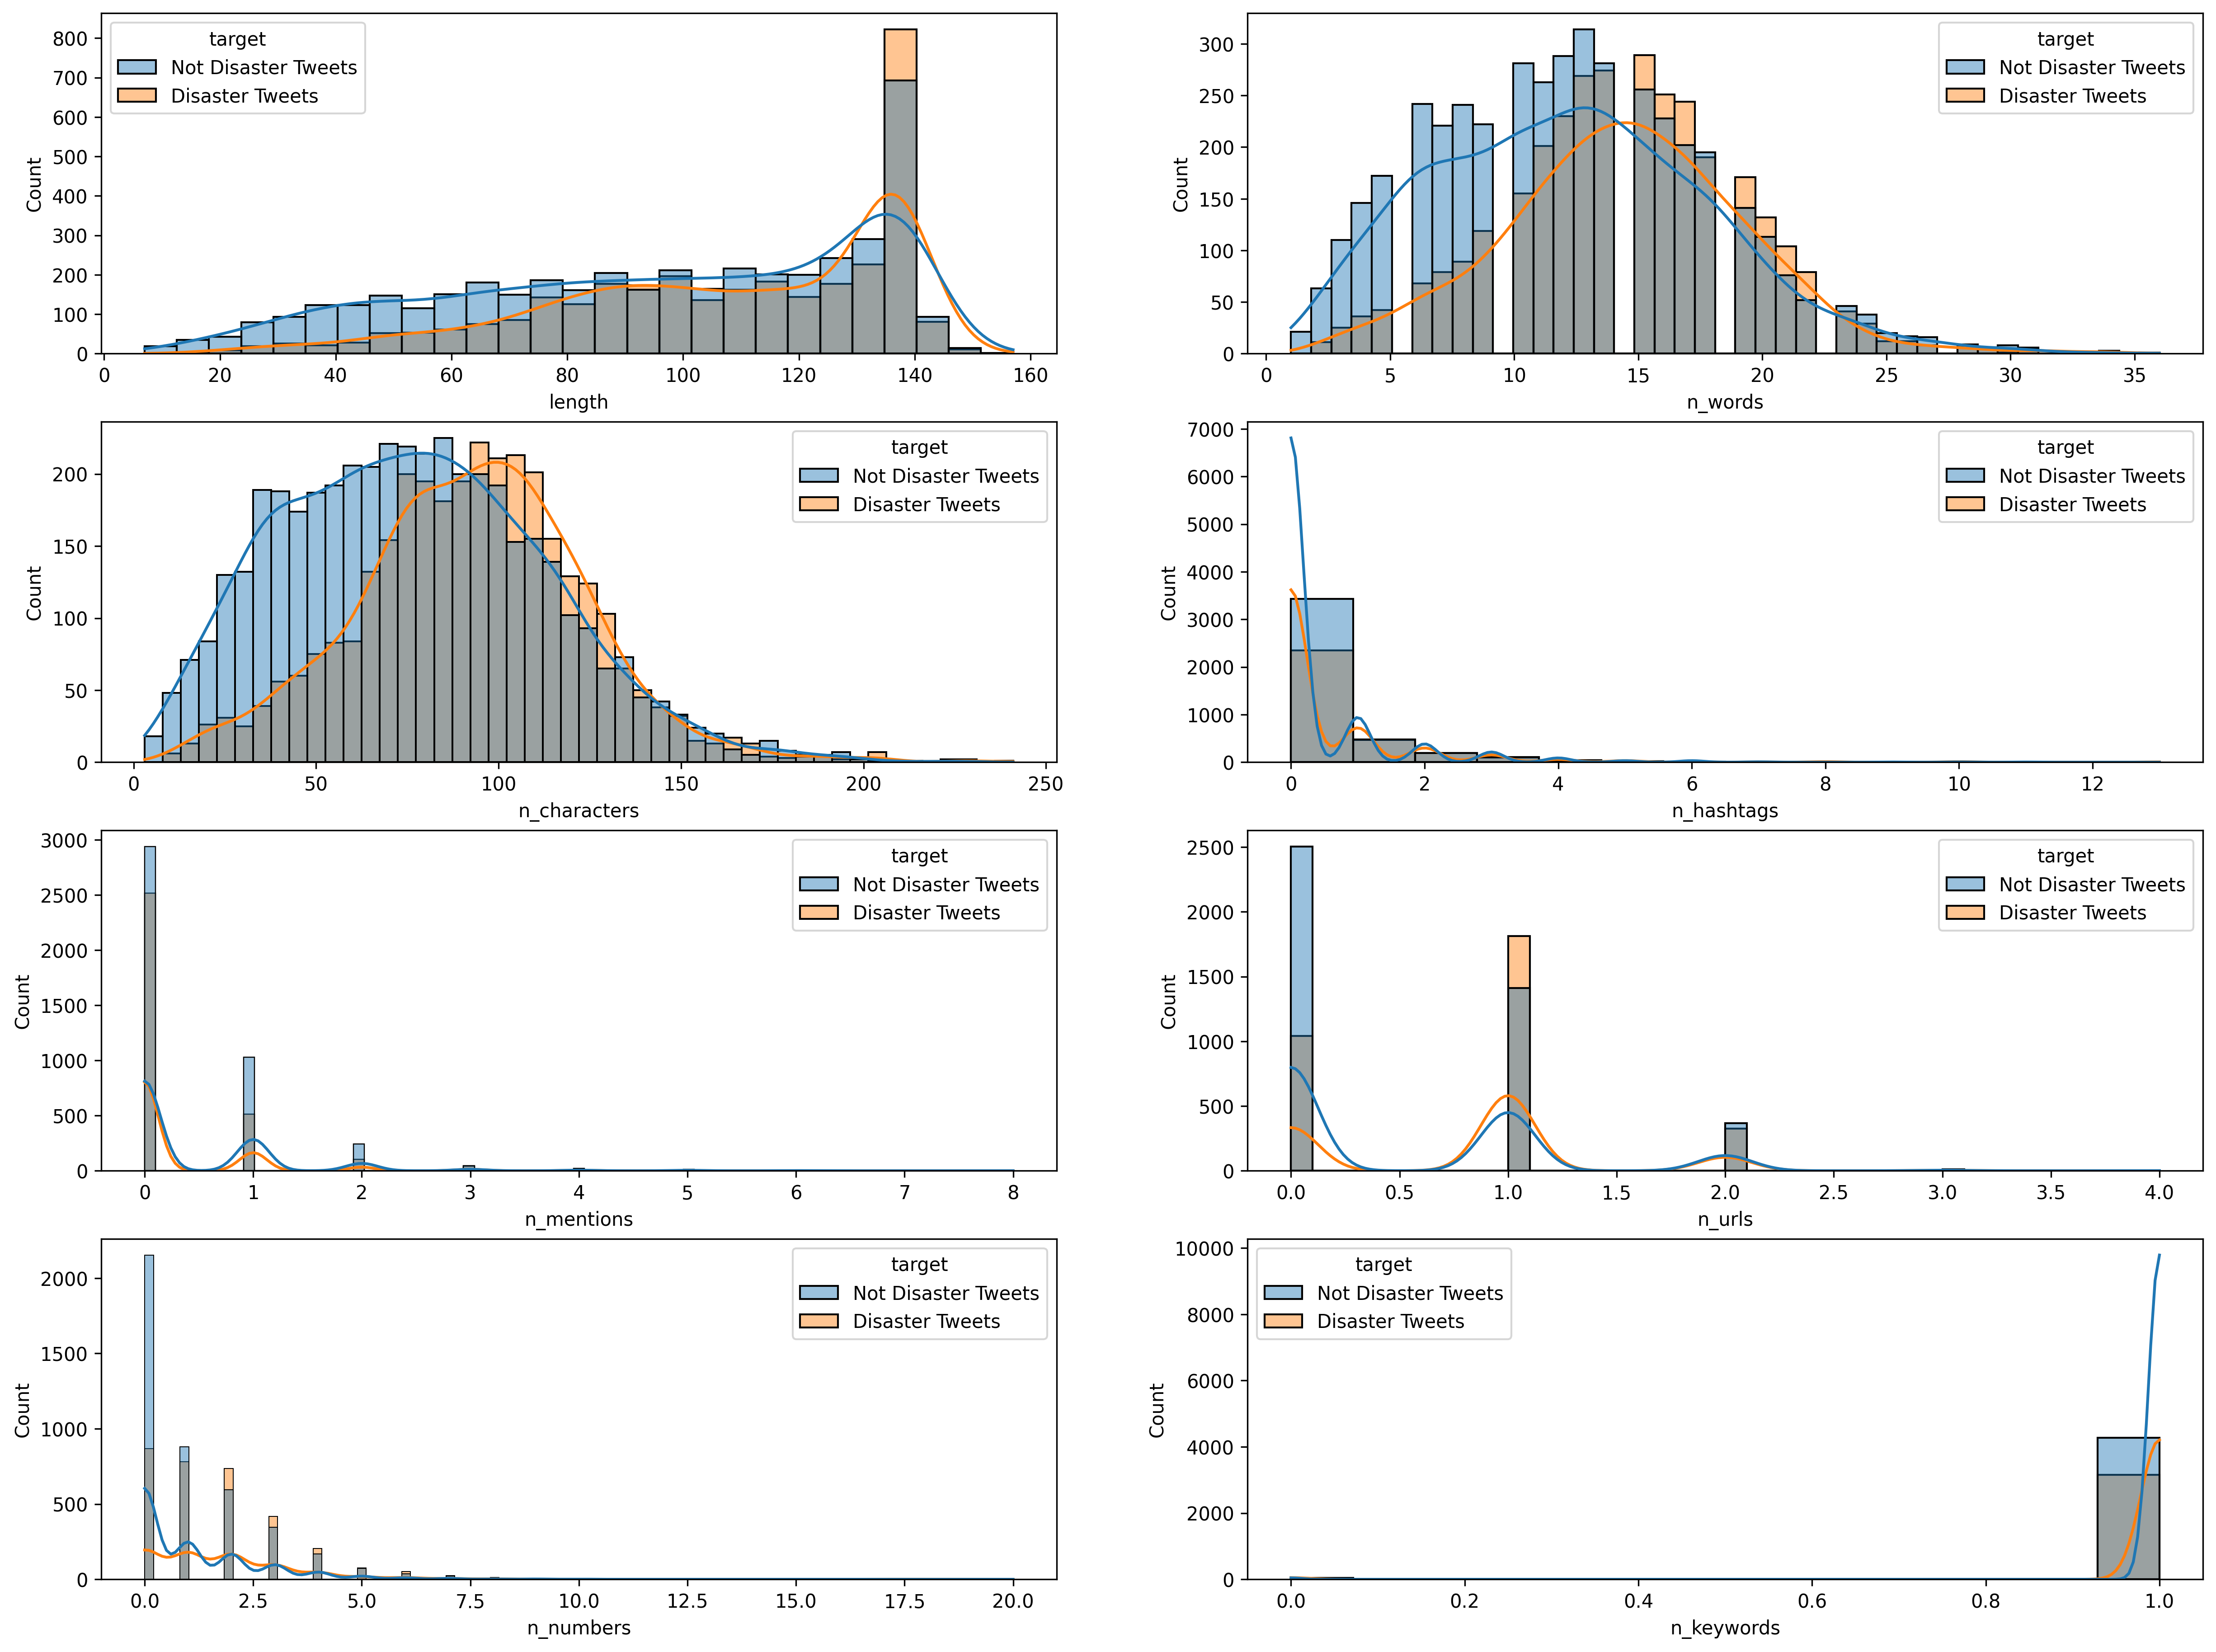

In [36]:
pd.set_option("mode.copy_on_write", False)
target = train_copy["target"].map({0: "Not Disaster Tweets", 1: "Disaster Tweets"})

plt.subplots(4, 2, figsize=(20, 15), dpi=300)
for i, col in enumerate(["length","n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers","n_emojis"]):
    plt.subplot(4, 2, i+1)
    sns.histplot(x=train_copy[col], hue=target, hue_order=["Not Disaster Tweets", "Disaster Tweets"], alpha=0.45, kde=True);

In [167]:
import random

SEED = 41125
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [125]:
X = train_copy.drop(["target"], axis=1)
y = train_copy["target"]

#Creating the training and validation set

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.50, stratify=y_val, shuffle=True, random_state=SEED)
X_train.head()



id         keyword                               location  \
7236  10364         weapons                                          
1560   2254    cliff%20fall                             Somewhere.   
4844   6898   mass%20murder                               Auckland   
999    1450  body%20bagging  Former Yugoslav Republic of Macedonia   
1712   2468        collided                  St. Joseph, Minnesota   

                                                   text  length  \
7236  router one latest ddo attack weapon anurl tcov...     100   
1560  go ibiza pop ah pill drunk amp fall cliff real...     121   
4844  hiroshima anumb year worst mass murder human h...     102   
999   ament editaxohaz let bag bodi begin lol aint c...     104   
1712  two train collid india pleas pray victim famil...      87   

                                             clean_text  n_words  \
7236  router one latest ddo attack weapon anurl tcov...       16   
1560  go ibiza pop ah pill drunk amp fall cliff real...       17   
4844  hiroshima anumb year worst mass murder human h...       18   
999   ament editaxohaz let bag bodi begin lol aint c...       12   
1712  two train collid india pleas pray victim famil...        9   

      n_characters  n_hashtags  n_mentions  n_urls  n_numbers  n_keywords  \
7236           110           4           0       1          0           1   
1560           113           0           3       0          0           1   
4844           103           0           0       1          4           1   
999             65           0           1       0          0           1   
1712            55           0           0       0          0           1   

                                         tokenized_text  \
7236  [19640, 13, 187, 19641, 27, 101, 3, 19642, 4, ...   
1560  [14, 8782, 1384, 1612, 3131, 1245, 8, 153, 373...   
4844  [92, 2, 29, 780, 129, 100, 529, 591, 177, 1261...   
999   [5, 7755, 86, 54, 30, 689, 139, 858, 7756, 508...   
1712  [83, 50, 125, 509, 144, 846, 565, 40, 409, 0, ...   

                 tokenized_keyword                        tokenized_location  
7236    [410, 0, 0, 0, 0, 0, 0, 0]                  [0, 0, 0, 0, 0, 0, 0, 0]  
1560  [161, 464, 0, 0, 0, 0, 0, 0]                [804, 0, 0, 0, 0, 0, 0, 0]  
4844   [44, 617, 0, 0, 0, 0, 0, 0]               [2587, 0, 0, 0, 0, 0, 0, 0]  
999    [80, 574, 0, 0, 0, 0, 0, 0]  [1148, 21227, 2298, 162, 21228, 0, 0, 0]  
1712    [404, 0, 0, 0, 0, 0, 0, 0]         [136, 4195, 21426, 0, 0, 0, 0, 0]

In [126]:
X_train_tokenized = X_train.loc[:, ["tokenized_text", "tokenized_keyword", "length","n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers","n_emojis"]]
X_val_tokenized = X_val.loc[:, ["tokenized_text", "tokenized_keyword", "length", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers", "n_emojis"]]
X_test_tokenized = X_test.loc[:, ["tokenized_text", "tokenized_keyword", "length", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers",  "n_emojis"]]

tokenized_X=dict()
tokenized_X["train"]=X_train_tokenized
tokenized_X["val"]=X_val_tokenized
tokenized_X["test"]=X_test_tokenized
display (tokenized_X["test"].head())
Y_s=dict()
Y_s["train"]=y_train
Y_s["val"]=y_val
Y_s["test"]=y_test



tokenized_text  \
5556  [349, 1859, 2544, 18, 515, 2555, 632, 515, 16,...   
6071  [709, 337, 1705, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5636  [4, 1129, 667, 1393, 1144, 2, 4, 1247, 4, 347,...   
1325  [4530, 682, 1761, 4531, 4530, 24, 647, 8359, 3...   
1478  [877, 4, 8639, 136, 1097, 224, 877, 3, 8640, 2...   

               tokenized_keyword  length  n_words  n_characters  n_hashtags  \
5556  [209, 0, 0, 0, 0, 0, 0, 0]     140       17           107           0   
6071  [409, 0, 0, 0, 0, 0, 0, 0]      32        3            19           0   
5636  [551, 0, 0, 0, 0, 0, 0, 0]     139       25           156           4   
1325  [223, 0, 0, 0, 0, 0, 0, 0]     112       12            80           0   
1478  [463, 0, 0, 0, 0, 0, 0, 0]     102       11            77           1   

      n_mentions  n_urls  n_numbers  n_keywords  
5556           0       1          2           1  
6071           0       0          0           1  
5636           0       2          4           1  
1325           0       1          1           1  
1478           0       1          1           1

In [127]:
print(tf.expand_dims(Y_s["test"], axis=-1).shape )


(749, 1)


In [128]:
from tensorflow.data import Dataset
datasets=dict()
for tipo in ["train", "val", "test"]:
  df=tokenized_X[tipo]
  text, keyword, counts = df["tokenized_text"].to_list(), df["tokenized_keyword"].to_list(), df.drop(["tokenized_text", "tokenized_keyword"], axis=1)
  data_text = Dataset.from_tensor_slices(text)
  data_keyword = Dataset.from_tensor_slices(keyword)
  data_counts = Dataset.from_tensor_slices(counts)
  data_labels = Dataset.from_tensor_slices(np.expand_dims(Y_s[tipo].values, axis=-1))

  datasets[tipo] = Dataset.zip(((data_text, data_keyword, data_counts), data_labels))


In [129]:
print(datasets["val"])

for tipo in ["train", "val", "test"]:
  datasets[tipo] = datasets[tipo].batch(32).prefetch(tf.data.AUTOTUNE)

<_ZipDataset element_spec=((TensorSpec(shape=(144,), dtype=tf.int32, name=None), TensorSpec(shape=(8,), dtype=tf.int32, name=None), TensorSpec(shape=(8,), dtype=tf.int64, name=None)), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>


In [130]:
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(np.unique(y_train), class_weight))
class_weight

{0: 0.8708551483420593, 1: 1.1741176470588235}

## Defining an architecture

As a baseline, we will consider that our dataset has 3 different types of data for each register:
1. Tokenized text
2. Tokenized keyword
3. Counts of specific text objects (hashtags, keywords, characters, words,...)

The first approach will be to consider simply the text and use LSTM as the recursive part of the network.

Some hyperparameters have been tested (manually). One of them is presented

## A Simple Recurrent Neural Network:

This time, a recurrent neural network architecture will be tested as well.



In [188]:

# Example dataset
texts = train_copy["text"]
labels = train_copy["target"]

# Step 1: Preprocessing the data
# Tokenize the text
tokenizer = Tokenizer(num_words=1000)  # Limit vocabulary size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

# Pad the sequences to make them all the same length
max_len = 8
X = pad_sequences(sequences, maxlen=max_len)


# Encode labels
y= labels
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=412294)

# Step 2: Build the RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=512, input_length=max_len),  # Embedding layer
    LSTM(32, return_sequences=False, activation='relu'),  # RNN layer with 32 units
    Dropout(0.2),
    Dense(32, activation='relu'),  # Output layer for binary classification

    Dense(8, activation='relu'),  # Output layer for binary classification
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])


In [197]:
%%time
LR=0.005
EPOCHS=100
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=7, verbose=1, factor=0.2)
early = EarlyStopping(monitor='val_f1_score', patience=12, verbose=1, restore_best_weights=True)


OPTIMIZER = Adam(learning_rate=LR,use_ema=True,
    ema_momentum=0.999,)
# Step 3: Compile the model
model.compile(optimizer=OPTIMIZER , loss='binary_crossentropy',metrics=[F1Score(average = "weighted", threshold=0.5), BinaryAccuracy()])
# Step 4: Train the model
history = model.fit(X_train,y_train, epochs=EPOCHS, batch_size=8, validation_split=0.2,callbacks=[reduceLR, early, ],)



Epoch 1/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - binary_accuracy: 0.7985 - f1_score: 0.7452 - loss: 0.4625 - val_binary_accuracy: 0.7421 - val_f1_score: 0.6791 - val_loss: 0.5227 - learning_rate: 0.0050
Epoch 2/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - binary_accuracy: 0.8180 - f1_score: 0.7702 - loss: 0.4011 - val_binary_accuracy: 0.7396 - val_f1_score: 0.6329 - val_loss: 0.5404 - learning_rate: 0.0050
Epoch 3/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.8395 - f1_score: 0.7942 - loss: 0.3625 - val_binary_accuracy: 0.7412 - val_f1_score: 0.7036 - val_loss: 0.6171 - learning_rate: 0.0050
Epoch 4/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8549 - f1_score: 0.8202 - loss: 0.3286 - val_binary_accuracy: 0.7454 - val_f1_score: 0.6878 - val_loss: 0.6938 - learning_rate: 0.0050
Epoch 5/100
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_accuracy: 0.8300 - f1_score: 0.7926 - loss: 0.3813 - val_binary_accuracy: 0.7521 - val_f1_score: 0.6

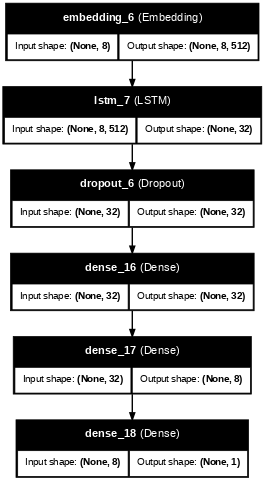

In [198]:
plot_model(model, show_layer_names=True, show_shapes=True, dpi=50)

In [199]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 8, 512)              │      11,662,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 32)                  │          69,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,935,750 (179.05 MB)

 Trainable params: 11,733,937 (44.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,201,813 (134.28 MB)

In [200]:
model.evaluate(X_test,y_test)

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.6930 - f1_score: 0.6631 - loss: 0.6722


[0.642487108707428, 0.6696764230728149, 0.7067468166351318]

### Visualization of training scores

The following function lets us visualize the scores.

In [201]:


def show_history(modelo, parameters=None):
    df_hist = pd.DataFrame(modelo.history)

    h,w=1,len(parameters)
    size=3
    margin=0.5
    plt.subplots(h,w, figsize=(w*(size+margin), h*(size+margin)), dpi=300)

    for i, col in enumerate(parameters):
        plt.subplot(1, len(parameters), i+1)
        param = col[0].replace('_', ' ').title()
        plt.plot(df_hist.index, df_hist[col[0]], label=f"Training {param}")
        plt.plot(df_hist.index, df_hist[col[1]], label=f"Validation {param}")
        plt.ylabel(col[0].capitalize().replace("_", " "))
        plt.xlabel("Epoch")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3, which="both")
        plt.title(f"{param} over epochs")

    #fig, axs = delete_empty_subplots(fig, axs)
    plt.tight_layout()
    plt.show()
    return


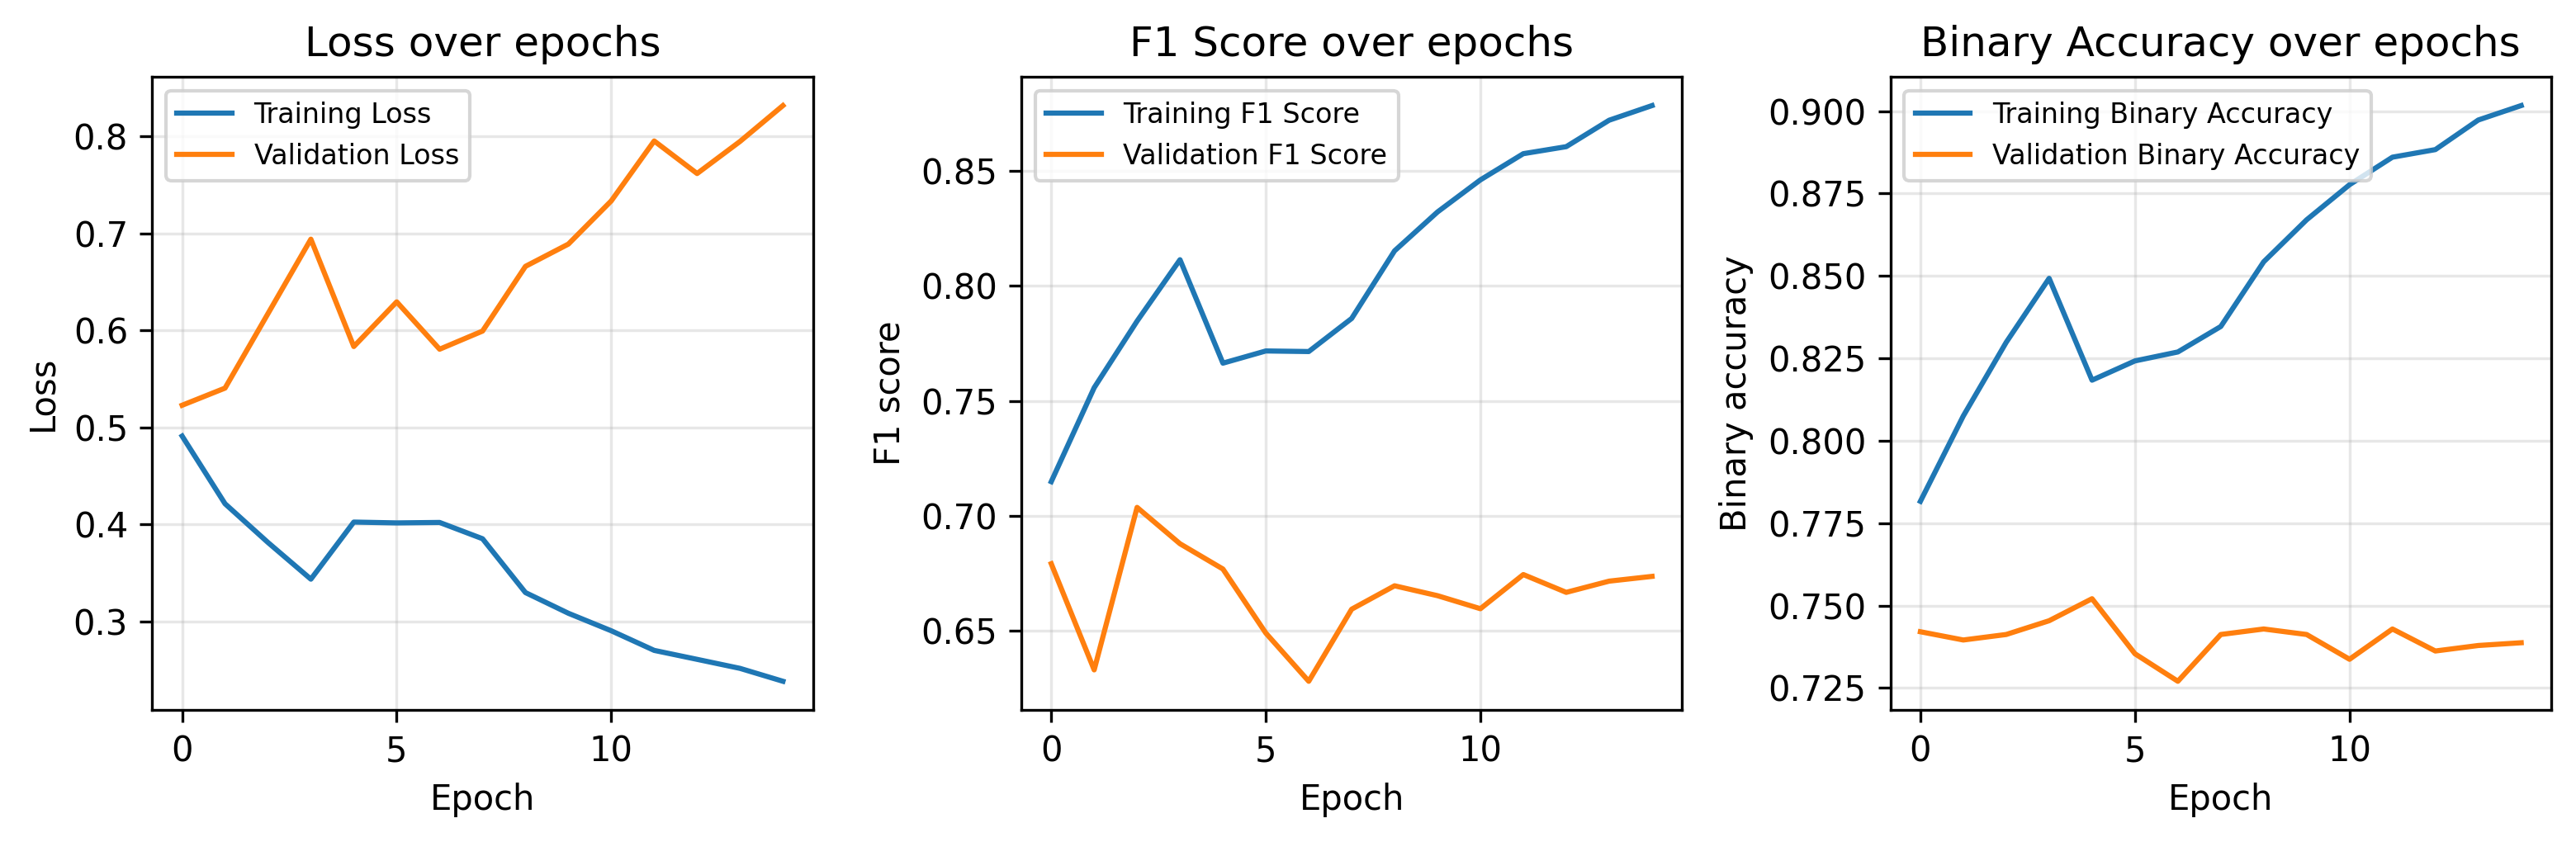

In [202]:
show_history(modelo=history, parameters=[["loss", "val_loss"],["f1_score", "val_f1_score"], ["binary_accuracy", "val_binary_accuracy"]])



We can see the confusion matrix too:

In [203]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


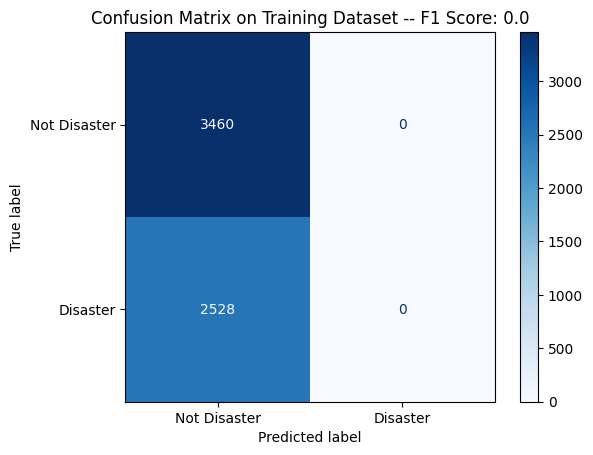

In [204]:
y_pred_train = model.predict(X_train)

displayConfusionMatrix(y_train, y_pred_train, "Training")

## A second architecture

Since we have three different types of data: word counting data, tokenized text and tokenized keywords.
The second approach will simply use each of them separately to get an output and then try a weighted average of the results as the final output layer



In [205]:
def get_baseline_model():
    tf.keras.backend.clear_session()
    # Model for text
    inp1 = Input(shape=(max_length_tweet,), name="text")
    x = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length_tweet)(inp1)
    x = Bidirectional(LSTM(16, dropout=0.4, recurrent_dropout=0.0))(x)
    out1 = Dense(1, activation="sigmoid")(x)

    # Model for keyword
    inp2 = Input(shape=(max_length_keyword,), name="keyword")
    t = Embedding(input_dim=vocab_size, output_dim=16, input_length=max_length_tweet)(inp2)
    t = Bidirectional(LSTM(4, dropout=0.4, recurrent_dropout=0.0))(t)
    out2 = Dense(1, activation="sigmoid")(t)

    # Model for word counts
    inp3 = Input(shape=(8,), name="counts")
    z = Dense(32, activation="relu")(inp3)
    z = Dropout(0.4)(z)
    z = Dense(16, activation="relu")(z)
    out3 = Dense(1, activation="sigmoid")(z)

    k = Concatenate()([out1, out2, out3])
    out = Dense(1, activation="sigmoid")(k)

    model = Model(inputs=[inp1, inp2, inp3], outputs=out)
    return model

model_base = get_baseline_model()
model_base.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ counts (InputLayer)       │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text (InputLayer)         │ (None, 144)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keyword (InputLayer)      │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │            288 │ counts[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 144, 16)        │        364,464 │ text[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 8, 16)          │        364,464 │ keyword[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 32)             │          4,224 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 8)              │            672 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16)             │            528 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │             33 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │              9 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             17 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3)              │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0],         │
│                           │                        │                │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │              4 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 734,703 (2.80 MB)

 Trainable params: 734,703 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

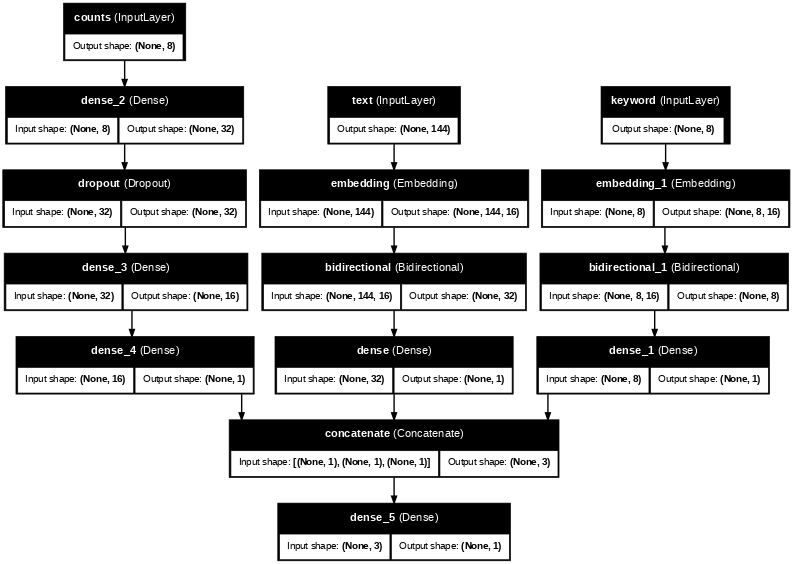

In [206]:

plot_model(model_base, show_layer_names=True, show_shapes=True, dpi=50)

In [207]:
LR = 0.001
EPOCHS=20
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
early = EarlyStopping(monitor='val_f1_score', patience=8, verbose=1, restore_best_weights=True)


OPTIMIZER = Adam(learning_rate=LR)
# Step 3: Compile the model
model_base.compile(optimizer=OPTIMIZER , loss='binary_crossentropy',metrics=[F1Score(average = "weighted", threshold=0.5), BinaryAccuracy()])
# Step 4: Train the model
history_base = model_base.fit(datasets["train"],
                        validation_data=datasets["val"],
                        epochs=EPOCHS,
                        callbacks=[reduceLR, early, ],
                        class_weight=class_weight
                       )

# Step 5: Evaluate the model

# Reshape y_true before evaluation if necessary


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - binary_accuracy: 0.4952 - f1_score: 0.5006 - loss: 0.7189 - val_binary_accuracy: 0.6016 - val_f1_score: 0.6511 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - binary_accuracy: 0.6422 - f1_score: 0.6558 - loss: 0.5978 - val_binary_accuracy: 0.7741 - val_f1_score: 0.7270 - val_loss: 0.5551 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - binary_accuracy: 0.8557 - f1_score: 0.8314 - loss: 0.5097 - val_binary_accuracy: 0.8235 - val_f1_score: 0.7755 - val_loss: 0.5101 - learning_rate: 0.0010
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - binary_accuracy: 0.8962 - f1_score: 0.8781 - loss: 0.4387 - val_binary_accuracy: 0.7767 - val_f1_score: 0.7362 - val_loss: 0.5079 - learning_rate: 0.0010
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - binary_accuracy: 0.9319 - f1_score: 0.9196 - loss: 0.3638 - val_binary_accuracy: 0.7660 - val_f1_score: 0.73

In [208]:


def show_history(modelo, parameters=None):
    df_hist = pd.DataFrame(modelo.history)

    h,w=1,len(parameters)
    size=3
    margin=0.5
    plt.subplots(h,w, figsize=(w*(size+margin), h*(size+margin)), dpi=300)

    for i, col in enumerate(parameters):
        plt.subplot(1, len(parameters), i+1)
        param = col[0].replace('_', ' ').title()
        plt.plot(df_hist.index, df_hist[col[0]], label=f"Training {param}")
        plt.plot(df_hist.index, df_hist[col[1]], label=f"Validation {param}")
        plt.ylabel(col[0].capitalize().replace("_", " "))
        plt.xlabel("Epoch")
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3, which="both")
        plt.title(f"{param} over epochs")

    #fig, axs = delete_empty_subplots(fig, axs)
    plt.tight_layout()
    plt.show()
    return


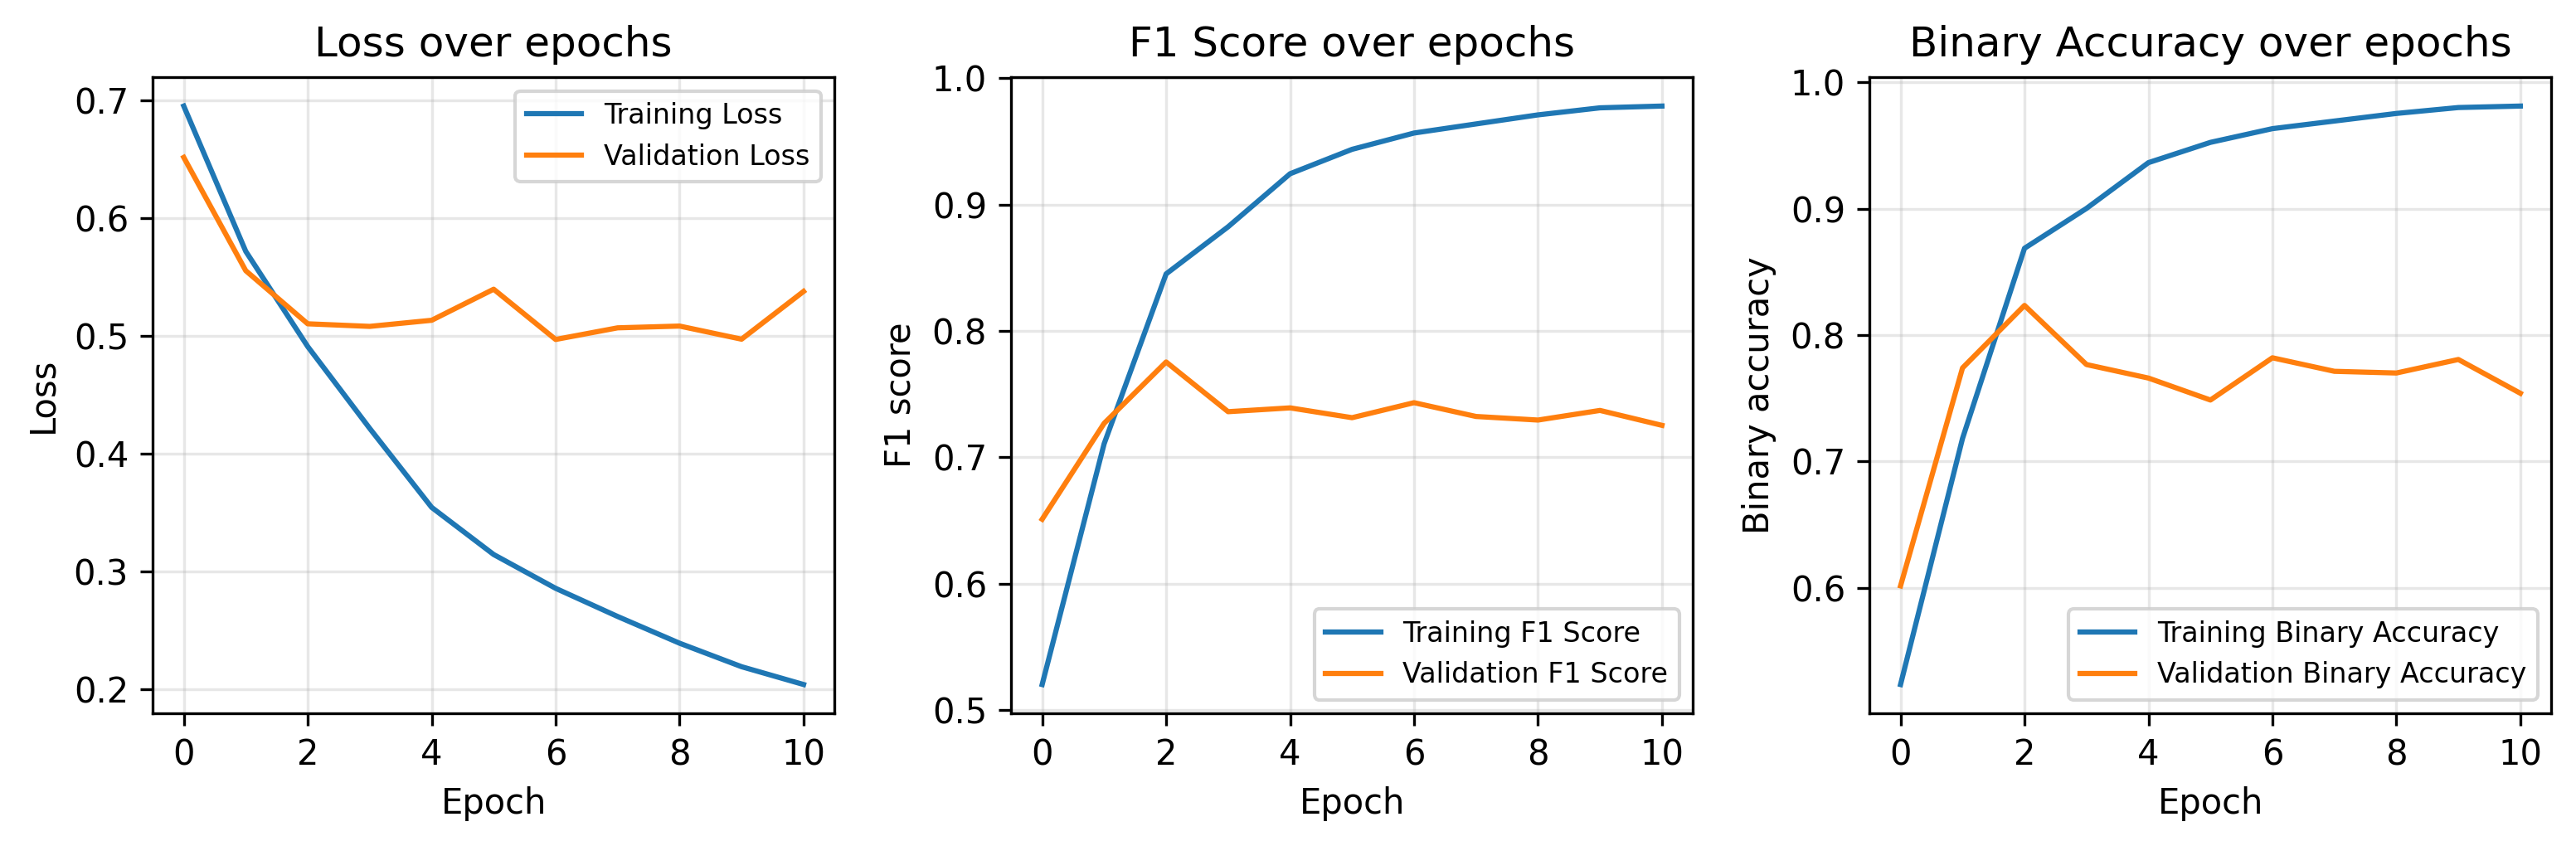

In [209]:
show_history(modelo=history_base, parameters=[["loss", "val_loss"],["f1_score", "val_f1_score"], ["binary_accuracy", "val_binary_accuracy"]])



In [210]:
model_base.evaluate(datasets["test"])

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7981 - f1_score: 0.7429 - loss: 0.5204


[0.5246300101280212, 0.7279028296470642, 0.7903871536254883]

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


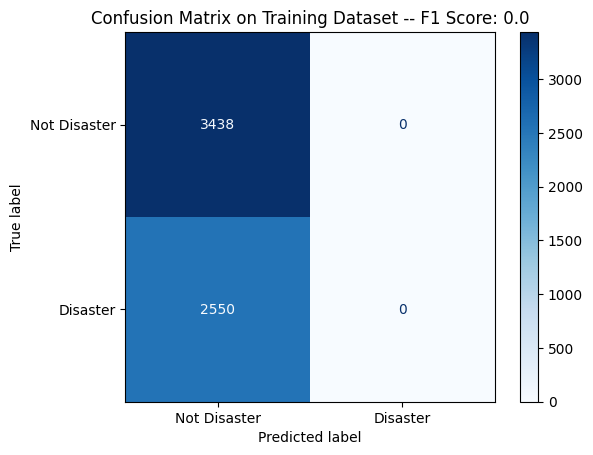

In [211]:
y_pred_train = model_base.predict(datasets["train"])

displayConfusionMatrix(Y_s["train"], y_pred_train, "Training")

# Generate the submission file

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [212]:
sample_submission = pd.read_csv(nlp_getting_started_path+"/sample_submission.csv")
sample_submission.head()

id  target
0   0       0
1   2       0
2   3       0
3   9       0
4  11       0

In [213]:
test_copy["clean_text"],test_copy["n_words"], test_copy["n_characters"], test_copy["n_hashtags"], test_copy["n_mentions"], test_copy["n_urls"],test_copy["n_numbers"],  = zip(*test_copy["text"].apply(lambda text: get_textData(text)))
test_copy["n_keywords"]  = list(zip(*test_copy["keyword"].apply(lambda text: get_textData(text))))[1]


test_copy["tokenized_text"] = list(get_tokens(test_copy["clean_text"].tolist(), max_length=max_length_tweet, fit=True, padding=True))
test_copy["tokenized_keyword"] = list(get_tokens(test_copy["keyword"].tolist(), max_length=max_length_keyword, fit=True, padding=True))
test_copy["tokenized_location"] = list(get_tokens(test_copy["location"].tolist(), max_length=max_length_keyword, fit=True, padding=True))

display(test_copy.head())

X_input_tokenized = test_copy.loc[:, ["tokenized_text", "tokenized_keyword", "length", "n_words", "n_characters", "n_hashtags", "n_mentions", "n_urls", "n_numbers",  "n_keywords"]]

text, keyword, counts = X_input_tokenized["tokenized_text"].to_list(), X_input_tokenized["tokenized_keyword"].to_list(), X_input_tokenized.drop(["tokenized_text", "tokenized_keyword"], axis=1)

data_text = Dataset.from_tensor_slices(text)
data_keyword = Dataset.from_tensor_slices(keyword)
data_counts = Dataset.from_tensor_slices(counts)

def input_fn(text, keyword, counts):
  return {"text": text, "keyword": keyword, "counts": counts}

datasets_input = Dataset.from_tensor_slices((text, keyword, counts)).map(input_fn)
datasets_input = datasets_input.batch(32).prefetch(tf.data.AUTOTUNE)


print (len(test_copy))

id keyword location                                               text  \
0   0                                            happen terribl car crash   
1   2                   heard ahashtag earthquak differ citi stay safe...   
2   3                   forest fire spot pond gees flee across street ...   
3   9                    apocalyps light ahashtag spokan ahashtag wildfir   
4  11                            typhoon soudelor kill anumb china taiwan   

   length                                     tokenized_text  \
0      34  [179, 61, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1      64  [340, 3, 242, 915, 165, 465, 236, 0, 0, 0, 0, ...   
2      96  [128, 6, 659, 795, 426, 178, 0, 0, 0, 0, 0, 0,...   
3      40  [330, 317, 3, 3, 113, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4      45  [470, 628, 18, 1, 400, 0, 0, 0, 0, 0, 0, 0, 0,...   

          tokenized_keyword        tokenized_location  \
0  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
1  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
2  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
3  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   
4  [0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0]   

                                          clean_text  n_words  n_characters  \
0                           happen terribl car crash        4            24   
1  heard ahashtag earthquak differ citi stay safe...        8            54   
2  forest fire spot pond gees flee across street ...        9            50   
3   apocalyps light ahashtag spokan ahashtag wildfir        6            48   
4           typhoon soudelor kill anumb china taiwan        6            40   

   n_hashtags  n_mentions  n_urls  n_numbers  n_keywords  
0           0           0       0          0           0  
1           1           0       0          0           0  
2           0           0       0          0           0  
3           2           0       0          0           0  
4           0           0       0          1           0

3263


In [214]:


print(datasets_input)
print (len(sample_submission))

<_PrefetchDataset element_spec={'text': TensorSpec(shape=(None, 144), dtype=tf.int32, name=None), 'keyword': TensorSpec(shape=(None, 8), dtype=tf.int32, name=None), 'counts': TensorSpec(shape=(None, 8), dtype=tf.int64, name=None)}>
3263


In [215]:
sample_submission["target"] = np.argmax(model_base.predict(datasets_input), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [216]:
sample_submission.describe()

id  target
count   3263.000000  3263.0
mean    5427.152927     0.0
std     3146.427221     0.0
min        0.000000     0.0
25%     2683.000000     0.0
50%     5500.000000     0.0
75%     8176.000000     0.0
max    10875.000000     0.0

In [217]:
sample_submission.to_csv("submission_base.csv", index=False)